# Imports

In [257]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import random as rand

from keras.utils import to_categorical
from keras.layers import Dense, Activation, Conv2D,Conv2DTranspose, Dropout, Reshape, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from keras.models import Sequential, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split

# Parameters

In [258]:
N_EPOCHS = 1500
BATCH_SIZE = 32
DATASET_SIZE = 700
TRAIN_DATA_SIZE = int(DATASET_SIZE - (DATASET_SIZE * 0.2))
LATENT_DIM = 128

# Data importing and pre-processing

In [259]:
df = pd.read_csv('dataset.csv', header=None)


df = df.values.reshape(DATASET_SIZE, 64, 64, 1)

x_real_train, x_real_test = train_test_split(df, test_size=0.2)


normalize dataset data into range of sigmoid [0,1], and put into batches

In [260]:
x_real_train = x_real_train.astype('float32')
x_real_train /=255


training_data = tf.data.Dataset.from_tensor_slices(x_real_train).shuffle(TRAIN_DATA_SIZE).batch(BATCH_SIZE)

Visualise random example from dataset

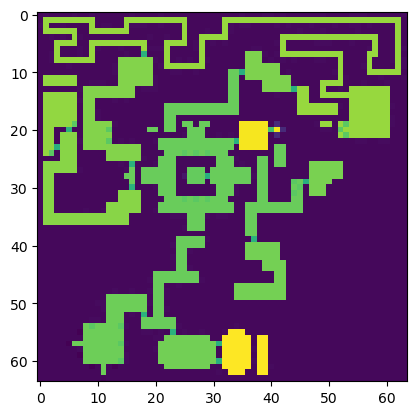

In [261]:
plt.imshow(df[rand.randint(0,DATASET_SIZE)])

# Generator Model

Create points in latent space to be fed into generator

In [262]:
def generate_generator_input(no_of_maps):
    input = tf.random.normal(shape=(no_of_maps, LATENT_DIM))
    
    return input

In [263]:
def make_generator():
    model = Sequential()
    
    model.add(Dense(LATENT_DIM*8*8, input_shape=(LATENT_DIM,)))

    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8,8,LATENT_DIM)))

    model.add(Dense(100, activation='relu'))
    
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(8,8,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(16,16,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(32,32,60)))
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=5, padding="same"))
    model.add(Activation("sigmoid"))
    
              
    model.summary()
    
    return model
    
    

# Discriminator Model

In [264]:

def make_discriminator():
    
    # 1st set of layers
    model = Sequential()
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same", input_shape=(64,64,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    

    model.add(Conv2D(32, kernel_size=4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    '''
    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    '''
    
    model.add(Dense(100, activation='relu'))
    #model.add(Activation='relu')
    
    # output layer
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1)) # Binary classification (2 outputs), so only 1 dense layer needed
    model.add(Activation('sigmoid'))
    
    model.summary()
    return model
    

Create the models from the functions

In [265]:
gen_model = make_generator()

disc_model = make_discriminator()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 8192)              1056768   
                                                                 
 batch_normalization_52 (Ba  (None, 8192)              32768     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_78 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_13 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 dense_42 (Dense)            (None, 8, 8, 100)         12900     
                                                                 
 conv2d_transpose_52 (Conv2  (None, 16, 16, 128)       204800    
 DTranspose)                                         

Next, test the untrained discriminator on the map of noise generated before

Negative values means fake, positive means real

## Loss and Optimizers

In [266]:
cross_entropy = BinaryCrossentropy(from_logits=True)



Discriminator loss, taken from: https://www.tensorflow.org/tutorials/generative/dcgan

In [267]:
def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [268]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers:

In [269]:
gen_optimizer = Adam(learning_rate =0.0001, beta_1=0.4)
disc_optimizer = Adam(learning_rate =0.0001, beta_1=0.4)

Discriminator accuracy

In [270]:
def compute_discrim_accuracy(real_output, fake_output):
    if real_output[0] >=0:
        
        if fake_output[0] <0:
            accuracy = (real_output[0] + fake_output[0]) / (real_output[0] + fake_output[0])
        else:
            accuracy = real_output[0]/ (real_output[0] + fake_output[0])
    elif fake_output[0] <0:
        accuracy = fake_output[0] / (real_output[0] + fake_output[0])
    else:
        accuracy = 0/ (real_output[0] + fake_output[0])
    
    return accuracy

## Training

Training step

In [271]:
@tf.function
def training_step(current_batch):
    
    noise_sample = generate_generator_input(BATCH_SIZE)
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_map = gen_model(noise_sample, training=True)
        print("generated map shape" + str(generated_map.shape))
        
        fake_output = disc_model(generated_map,  training=True)
        real_output = disc_model(current_batch, training=True)
        

        gen_loss = generator_loss(fake_output=fake_output)
        disc_loss = discrim_loss(real_output=real_output, fake_output=fake_output)

        disc_accuracy = compute_discrim_accuracy(real_output, fake_output)

        

    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

    return gen_loss, disc_loss, disc_accuracy

Train models

In [272]:
def train(dataset, N_EPOCHS):

    gen_losses = []
    disc_losses = []

    disc_accuracies = []
    
    img_seed = generate_generator_input(1)

    for epoch in range(N_EPOCHS):
        gen_losses_for_epoch = []
        disc_losses_for_epoch = []

        disc_accuracies_for_epoch = []

        print("epoch = " + str(epoch))

        for map_batch in dataset:
            
            
            gen_loss, disc_loss, disc_accuracy = training_step(map_batch)

            gen_losses_for_epoch.append(gen_loss)
            disc_losses_for_epoch.append(disc_loss)
            disc_accuracies.append(disc_accuracy)
        
        avg_gen_loss = sum(gen_losses_for_epoch) / TRAIN_DATA_SIZE
        avg_disc_loss = sum(disc_losses_for_epoch) / TRAIN_DATA_SIZE

        avg_disc_accuracy = sum(disc_accuracies_for_epoch) / TRAIN_DATA_SIZE

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        disc_accuracies.append(avg_disc_accuracy)

        print("Gen loss = " + str(avg_gen_loss))
        print("Disc loss = " + str(avg_disc_loss))

        print("Disc accuracy = " + str(avg_disc_accuracy))
# generate and show a map after 10 epochs

        if epoch % 10 == 0:
            
            generated_map = gen_model(img_seed, training=False)
            generated_map *= 255
            generated_map = generated_map.numpy()
            generated_map.reshape(64,64)
            generated_map = np.round(generated_map,0)
            generated_map = generated_map.tolist()
            plt.imshow(generated_map[0])
            plt.show()
    
    input_for_map_after_training = generate_generator_input(img_seed)
    generated_map = gen_model(input_for_map_after_training, training=False)

    

    return gen_losses, disc_losses, generated_map, disc_accuracies


Train GAN

epoch = 0
generated map shape(32, 64, 64, 1)


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


generated map shape(32, 64, 64, 1)
generated map shape(32, 64, 64, 1)
Gen loss = tf.Tensor(0.020522555, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044582058, shape=(), dtype=float32)
Disc accuracy = 0.0


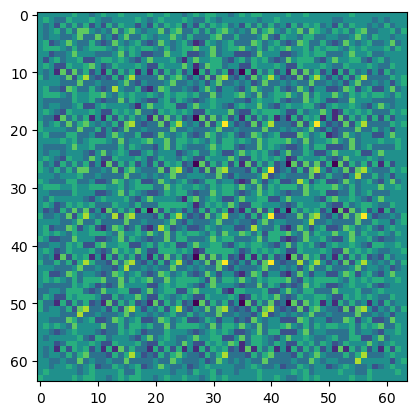

epoch = 1
Gen loss = tf.Tensor(0.021537822, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04269004, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 2
Gen loss = tf.Tensor(0.024520272, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037912145, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 3
Gen loss = tf.Tensor(0.0232164, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.038534254, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 4
Gen loss = tf.Tensor(0.02428419, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03819273, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 5
Gen loss = tf.Tensor(0.022650467, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04258854, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 6
Gen loss = tf.Tensor(0.017592916, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.052270256, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 7
Gen loss = tf.Tensor(0.019566776, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.060160022, shape=()

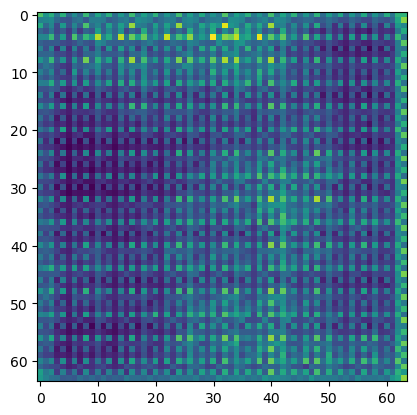

epoch = 11
Gen loss = tf.Tensor(0.02165754, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05020558, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 12
Gen loss = tf.Tensor(0.018555775, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.052050553, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 13
Gen loss = tf.Tensor(0.020395061, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04925535, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 14
Gen loss = tf.Tensor(0.019290995, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05167587, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 15
Gen loss = tf.Tensor(0.0194521, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.051889632, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 16
Gen loss = tf.Tensor(0.018352667, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.053005762, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 17
Gen loss = tf.Tensor(0.018112337, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05160094, sh

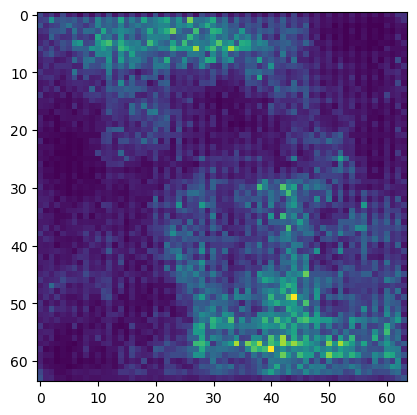

epoch = 21
Gen loss = tf.Tensor(0.019410416, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.049713753, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 22
Gen loss = tf.Tensor(0.020009639, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04924238, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 23
Gen loss = tf.Tensor(0.020521333, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04848526, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 24
Gen loss = tf.Tensor(0.02083865, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048414823, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 25
Gen loss = tf.Tensor(0.021578413, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.047303323, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 26
Gen loss = tf.Tensor(0.020216268, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.047795765, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 27
Gen loss = tf.Tensor(0.021032855, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.047758657

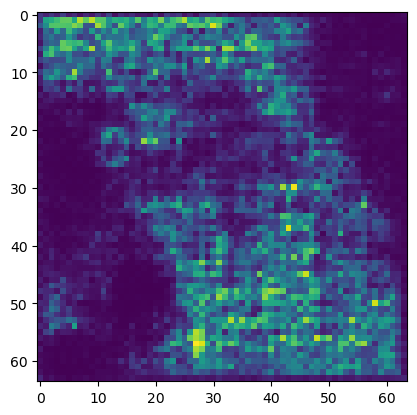

epoch = 31
Gen loss = tf.Tensor(0.021180717, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.047992542, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 32
Gen loss = tf.Tensor(0.021392867, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04739998, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 33
Gen loss = tf.Tensor(0.021181693, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.047542267, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 34
Gen loss = tf.Tensor(0.021697477, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04674238, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 35
Gen loss = tf.Tensor(0.022014592, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.047209848, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 36
Gen loss = tf.Tensor(0.02150276, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046999052, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 37
Gen loss = tf.Tensor(0.021179492, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046818577

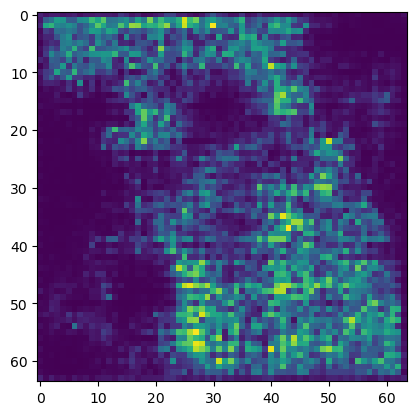

epoch = 41
Gen loss = tf.Tensor(0.021530526, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04628801, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 42
Gen loss = tf.Tensor(0.021393182, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045902923, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 43
Gen loss = tf.Tensor(0.022787886, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04594534, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 44
Gen loss = tf.Tensor(0.022910371, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04572152, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 45
Gen loss = tf.Tensor(0.021898726, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045024175, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 46
Gen loss = tf.Tensor(0.021635327, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044514135, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 47
Gen loss = tf.Tensor(0.023393167, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04587697,

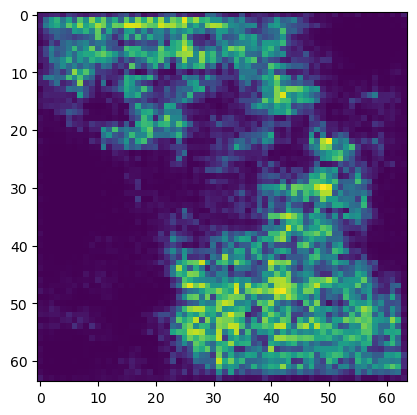

epoch = 51
Gen loss = tf.Tensor(0.024156211, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045202192, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 52
Gen loss = tf.Tensor(0.02297163, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044256836, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 53
Gen loss = tf.Tensor(0.021756316, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043237023, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 54
Gen loss = tf.Tensor(0.023690252, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04531809, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 55
Gen loss = tf.Tensor(0.025299422, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043699905, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 56
Gen loss = tf.Tensor(0.02465102, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.038710665, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 57
Gen loss = tf.Tensor(0.023503175, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04465276,

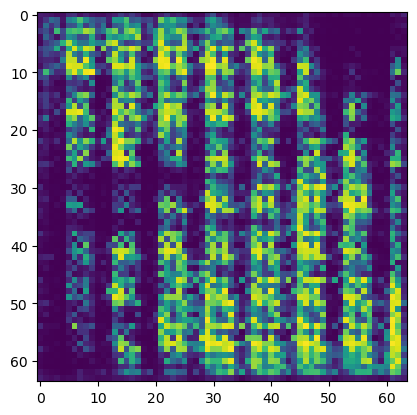

epoch = 61
Gen loss = tf.Tensor(0.025064062, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044936333, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 62
Gen loss = tf.Tensor(0.027991744, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04235345, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 63
Gen loss = tf.Tensor(0.02585158, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04030443, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 64
Gen loss = tf.Tensor(0.023273757, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.040256795, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 65
Gen loss = tf.Tensor(0.028346026, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037165776, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 66
Gen loss = tf.Tensor(0.025271771, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046736814, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 67
Gen loss = tf.Tensor(0.025835294, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.041157883

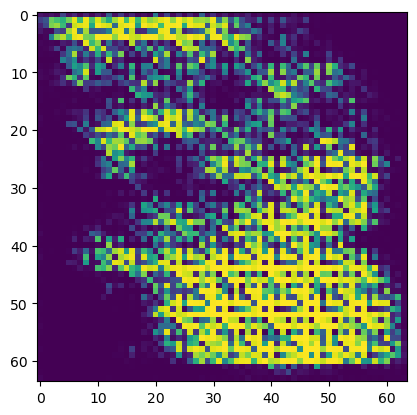

epoch = 71
Gen loss = tf.Tensor(0.02794439, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.038922284, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 72
Gen loss = tf.Tensor(0.027360598, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.035862863, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 73
Gen loss = tf.Tensor(0.027477043, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.038698364, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 74
Gen loss = tf.Tensor(0.026817394, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.036527798, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 75
Gen loss = tf.Tensor(0.025234539, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037988696, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 76
Gen loss = tf.Tensor(0.026689762, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.038900506, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 77
Gen loss = tf.Tensor(0.030275634, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0343792

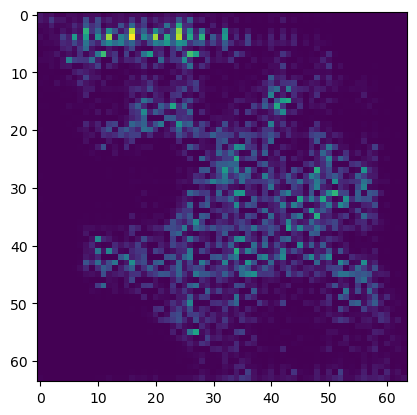

epoch = 81
Gen loss = tf.Tensor(0.024795594, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.033861175, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 82
Gen loss = tf.Tensor(0.025876632, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0410506, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 83
Gen loss = tf.Tensor(0.021399315, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046064, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 84
Gen loss = tf.Tensor(0.025672665, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04444311, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 85
Gen loss = tf.Tensor(0.02439467, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044733968, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 86
Gen loss = tf.Tensor(0.02500249, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04054952, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 87
Gen loss = tf.Tensor(0.0236749, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043677095, shape=

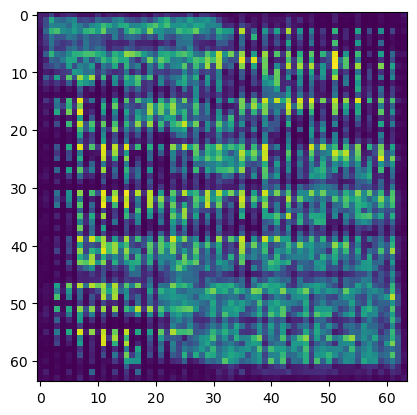

epoch = 91
Gen loss = tf.Tensor(0.026437797, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04388793, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 92
Gen loss = tf.Tensor(0.023134658, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04393602, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 93
Gen loss = tf.Tensor(0.022823263, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04299139, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 94
Gen loss = tf.Tensor(0.02206609, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044306524, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 95
Gen loss = tf.Tensor(0.022894256, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043779325, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 96
Gen loss = tf.Tensor(0.022858882, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043055873, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 97
Gen loss = tf.Tensor(0.02384505, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04291554, s

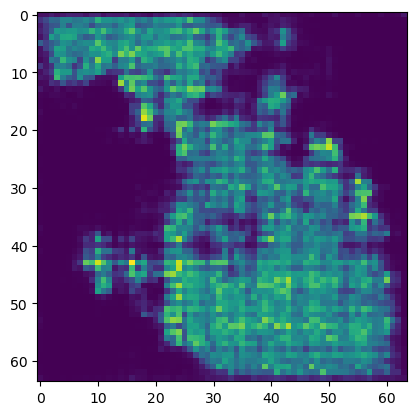

epoch = 101
Gen loss = tf.Tensor(0.023582688, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.042960223, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 102
Gen loss = tf.Tensor(0.02330502, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.042077474, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 103
Gen loss = tf.Tensor(0.024374384, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.041701384, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 104
Gen loss = tf.Tensor(0.02395115, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04261788, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 105
Gen loss = tf.Tensor(0.02419844, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.043103825, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 106
Gen loss = tf.Tensor(0.025139771, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04157025, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 107
Gen loss = tf.Tensor(0.023111414, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0428

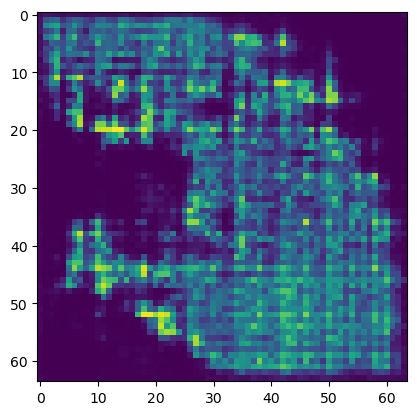

epoch = 111
Gen loss = tf.Tensor(0.02498923, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.042204354, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 112
Gen loss = tf.Tensor(0.025084402, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.041410748, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 113
Gen loss = tf.Tensor(0.02379071, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.041777004, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 114
Gen loss = tf.Tensor(0.024272947, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.041538198, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 115
Gen loss = tf.Tensor(0.02453489, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.041395206, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 116
Gen loss = tf.Tensor(0.023983594, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04195366, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 117
Gen loss = tf.Tensor(0.024921248, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.040

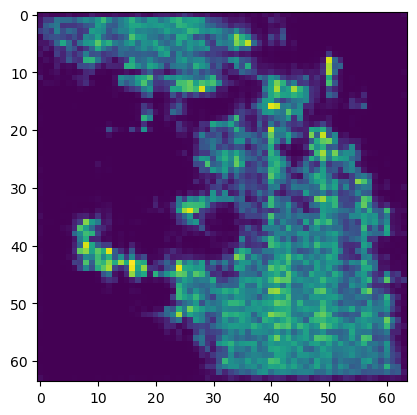

epoch = 121
Gen loss = tf.Tensor(0.024821283, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.040566154, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 122
Gen loss = tf.Tensor(0.024569478, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.040436935, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 123
Gen loss = tf.Tensor(0.024239445, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04102346, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 124
Gen loss = tf.Tensor(0.026486829, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.039938334, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 125
Gen loss = tf.Tensor(0.025056133, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.039734527, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 126
Gen loss = tf.Tensor(0.026035478, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03847941, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 127
Gen loss = tf.Tensor(0.026052475, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0

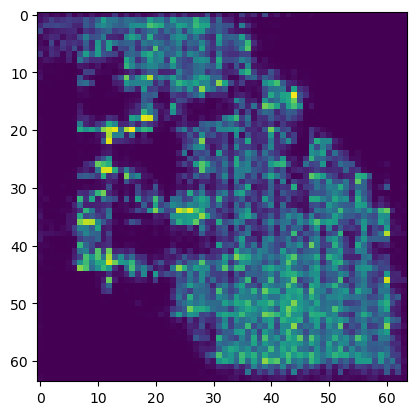

epoch = 131
Gen loss = tf.Tensor(0.026352575, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03790309, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 132
Gen loss = tf.Tensor(0.026693279, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03827424, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 133
Gen loss = tf.Tensor(0.02472364, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.040207304, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 134
Gen loss = tf.Tensor(0.026598826, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03873707, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 135
Gen loss = tf.Tensor(0.026328025, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.038313445, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 136
Gen loss = tf.Tensor(0.026252255, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.038343724, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 137
Gen loss = tf.Tensor(0.02582201, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0387

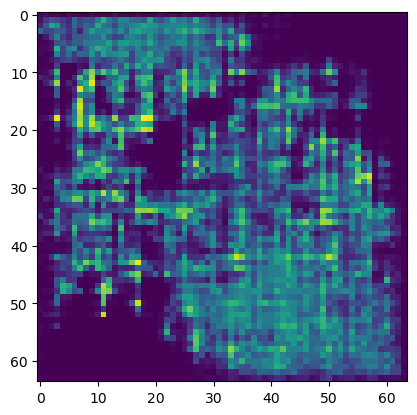

epoch = 141
Gen loss = tf.Tensor(0.026149122, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037938043, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 142
Gen loss = tf.Tensor(0.0275248, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.036950354, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 143
Gen loss = tf.Tensor(0.02653497, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037337635, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 144
Gen loss = tf.Tensor(0.027830096, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037203625, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 145
Gen loss = tf.Tensor(0.026840175, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037539054, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 146
Gen loss = tf.Tensor(0.02696325, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.038270615, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 147
Gen loss = tf.Tensor(0.028183825, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.036

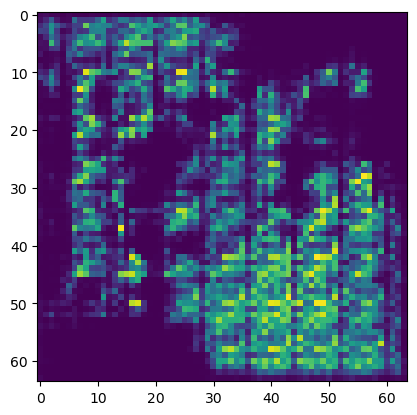

epoch = 151
Gen loss = tf.Tensor(0.030613419, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.032433726, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 152
Gen loss = tf.Tensor(0.03565062, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.029091625, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 153
Gen loss = tf.Tensor(0.03366478, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.033504296, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 154
Gen loss = tf.Tensor(0.034699243, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.028260984, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 155
Gen loss = tf.Tensor(0.03167398, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03430468, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 156
Gen loss = tf.Tensor(0.039859224, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.029005323, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 157
Gen loss = tf.Tensor(0.047458477, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.023

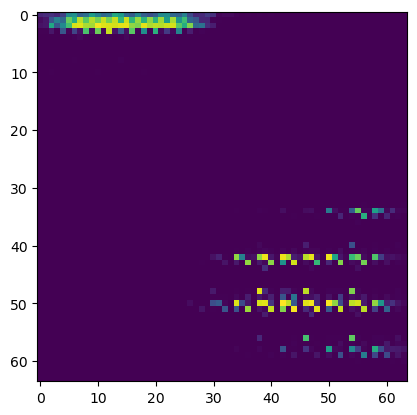

epoch = 161
Gen loss = tf.Tensor(0.05620341, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012689833, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 162
Gen loss = tf.Tensor(0.05013357, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.019301048, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 163
Gen loss = tf.Tensor(0.049416546, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024149321, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 164
Gen loss = tf.Tensor(0.035954695, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03217708, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 165
Gen loss = tf.Tensor(0.03866722, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.030199474, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 166
Gen loss = tf.Tensor(0.035494328, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.034051538, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 167
Gen loss = tf.Tensor(0.04496231, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0232

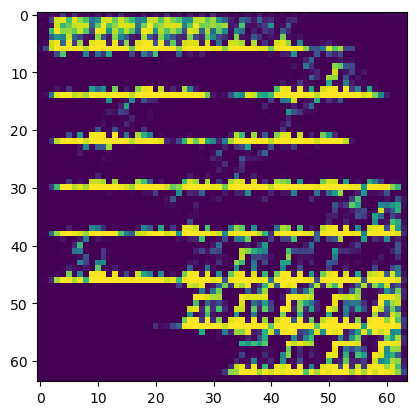

epoch = 171
Gen loss = tf.Tensor(0.042497884, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.025245639, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 172
Gen loss = tf.Tensor(0.045011383, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02199854, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 173
Gen loss = tf.Tensor(0.058029283, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0152235795, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 174
Gen loss = tf.Tensor(0.061186295, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011592923, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 175
Gen loss = tf.Tensor(0.04358788, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.027957942, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 176
Gen loss = tf.Tensor(0.04584505, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.027706362, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 177
Gen loss = tf.Tensor(0.042186182, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0

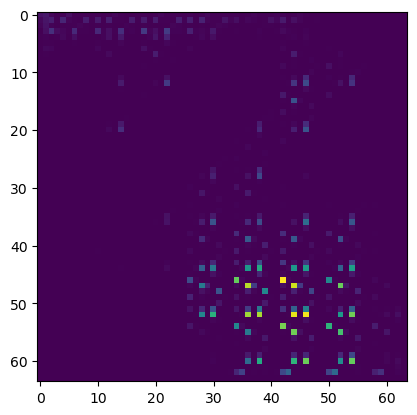

epoch = 181
Gen loss = tf.Tensor(0.07201956, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0075866026, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 182
Gen loss = tf.Tensor(0.06301931, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014062681, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 183
Gen loss = tf.Tensor(0.05290876, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018851371, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 184
Gen loss = tf.Tensor(0.04204485, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.025198402, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 185
Gen loss = tf.Tensor(0.04618893, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.022619018, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 186
Gen loss = tf.Tensor(0.044791143, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024257142, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 187
Gen loss = tf.Tensor(0.04389294, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0242

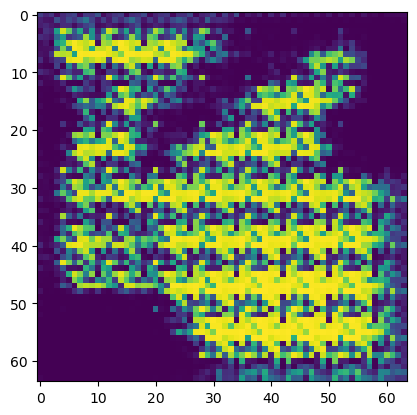

epoch = 191
Gen loss = tf.Tensor(0.041473076, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.028115762, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 192
Gen loss = tf.Tensor(0.03342848, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.033564012, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 193
Gen loss = tf.Tensor(0.02415118, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.038844172, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 194
Gen loss = tf.Tensor(0.033688042, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.026370192, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 195
Gen loss = tf.Tensor(0.033130262, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.028254265, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 196
Gen loss = tf.Tensor(0.035095572, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.030696508, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 197
Gen loss = tf.Tensor(0.031794187, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0

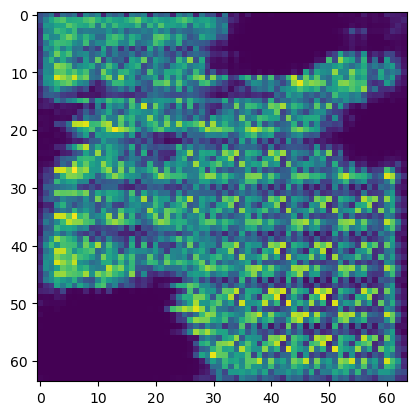

epoch = 201
Gen loss = tf.Tensor(0.03898708, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.032373607, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 202
Gen loss = tf.Tensor(0.036513355, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.029550055, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 203
Gen loss = tf.Tensor(0.037289746, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.027245026, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 204
Gen loss = tf.Tensor(0.039217833, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02428641, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 205
Gen loss = tf.Tensor(0.038139395, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.027315507, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 206
Gen loss = tf.Tensor(0.039758373, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.027040465, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 207
Gen loss = tf.Tensor(0.040251493, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0

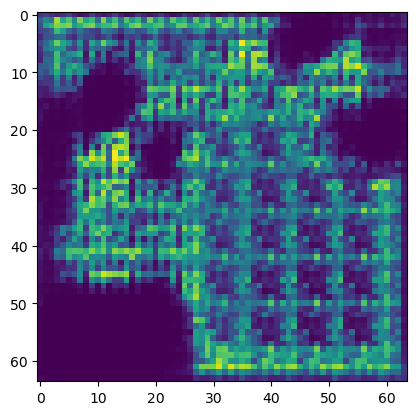

epoch = 211
Gen loss = tf.Tensor(0.03766014, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02864921, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 212
Gen loss = tf.Tensor(0.043987222, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.025220763, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 213
Gen loss = tf.Tensor(0.045380373, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024203828, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 214
Gen loss = tf.Tensor(0.046014804, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.023990482, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 215
Gen loss = tf.Tensor(0.04483301, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02820674, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 216
Gen loss = tf.Tensor(0.044952586, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02781994, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 217
Gen loss = tf.Tensor(0.05705536, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01766

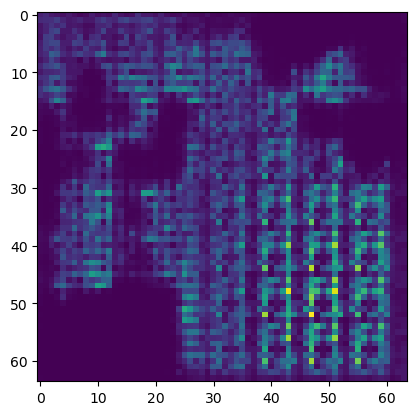

epoch = 221
Gen loss = tf.Tensor(0.034038525, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.027333116, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 222
Gen loss = tf.Tensor(0.04041445, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024509322, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 223
Gen loss = tf.Tensor(0.045289427, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020439357, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 224
Gen loss = tf.Tensor(0.039171044, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.025565496, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 225
Gen loss = tf.Tensor(0.040279865, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.026664758, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 226
Gen loss = tf.Tensor(0.044060417, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0235255, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 227
Gen loss = tf.Tensor(0.047787722, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02

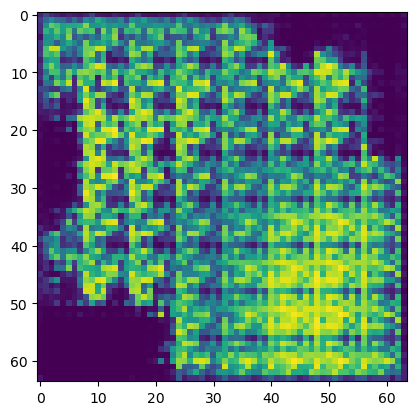

epoch = 231
Gen loss = tf.Tensor(0.044990536, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.022767782, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 232
Gen loss = tf.Tensor(0.04778492, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02054422, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 233
Gen loss = tf.Tensor(0.048895158, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02001332, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 234
Gen loss = tf.Tensor(0.044569552, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02195525, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 235
Gen loss = tf.Tensor(0.04140645, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.025276136, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 236
Gen loss = tf.Tensor(0.03881787, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0266916, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 237
Gen loss = tf.Tensor(0.038907625, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0275592

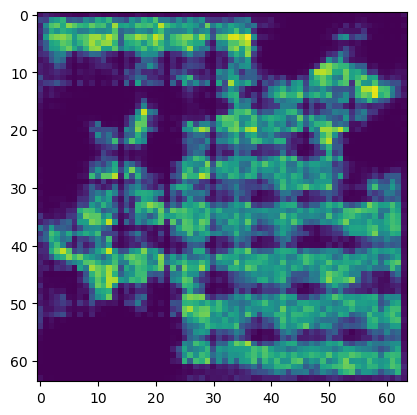

epoch = 241
Gen loss = tf.Tensor(0.04362129, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.026668074, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 242
Gen loss = tf.Tensor(0.04060473, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.027660642, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 243
Gen loss = tf.Tensor(0.040305573, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.027683029, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 244
Gen loss = tf.Tensor(0.037586264, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.028786598, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 245
Gen loss = tf.Tensor(0.037265446, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0293248, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 246
Gen loss = tf.Tensor(0.040004876, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.026000487, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 247
Gen loss = tf.Tensor(0.03927082, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0263

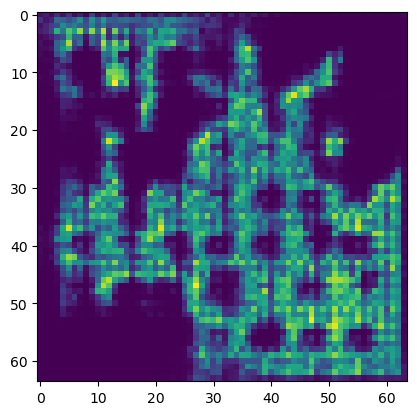

epoch = 251
Gen loss = tf.Tensor(0.041979477, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.025332421, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 252
Gen loss = tf.Tensor(0.04487118, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.023614783, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 253
Gen loss = tf.Tensor(0.04313038, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.025245616, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 254
Gen loss = tf.Tensor(0.044683754, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024380092, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 255
Gen loss = tf.Tensor(0.045163337, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.023086743, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 256
Gen loss = tf.Tensor(0.050739683, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.019955762, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 257
Gen loss = tf.Tensor(0.05079285, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01

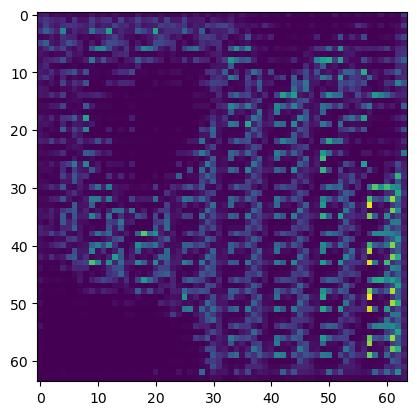

epoch = 261
Gen loss = tf.Tensor(0.06082802, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014374406, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 262
Gen loss = tf.Tensor(0.06132164, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014457614, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 263
Gen loss = tf.Tensor(0.054537687, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.019577, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 264
Gen loss = tf.Tensor(0.053695086, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.023271423, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 265
Gen loss = tf.Tensor(0.052229237, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.023996158, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 266
Gen loss = tf.Tensor(0.055004854, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02246562, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 267
Gen loss = tf.Tensor(0.052845202, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01903

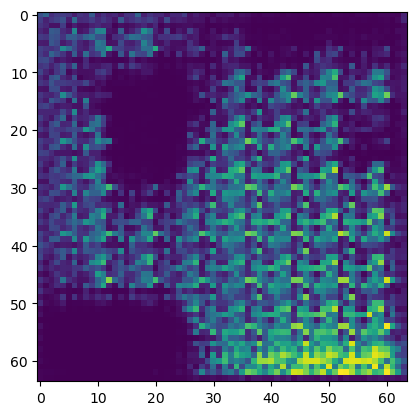

epoch = 271
Gen loss = tf.Tensor(0.04734401, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.022442667, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 272
Gen loss = tf.Tensor(0.050156217, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020982344, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 273
Gen loss = tf.Tensor(0.049482208, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018195083, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 274
Gen loss = tf.Tensor(0.04824382, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.019646568, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 275
Gen loss = tf.Tensor(0.049329255, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020226803, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 276
Gen loss = tf.Tensor(0.05817378, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015616374, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 277
Gen loss = tf.Tensor(0.05834581, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017

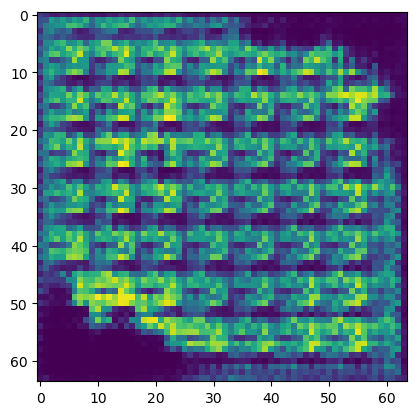

epoch = 281
Gen loss = tf.Tensor(0.066477165, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0138288895, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 282
Gen loss = tf.Tensor(0.053562842, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020247823, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 283
Gen loss = tf.Tensor(0.06610471, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015096191, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 284
Gen loss = tf.Tensor(0.050610658, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02024443, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 285
Gen loss = tf.Tensor(0.055839837, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016021771, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 286
Gen loss = tf.Tensor(0.047916524, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018444428, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 287
Gen loss = tf.Tensor(0.056998312, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.

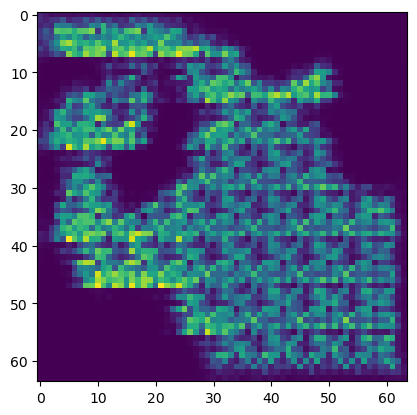

epoch = 291
Gen loss = tf.Tensor(0.050149776, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.021045556, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 292
Gen loss = tf.Tensor(0.049680803, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.021956293, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 293
Gen loss = tf.Tensor(0.046654496, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024237217, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 294
Gen loss = tf.Tensor(0.055717766, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0199762, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 295
Gen loss = tf.Tensor(0.05699585, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017094482, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 296
Gen loss = tf.Tensor(0.053422827, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018415557, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 297
Gen loss = tf.Tensor(0.05535334, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017

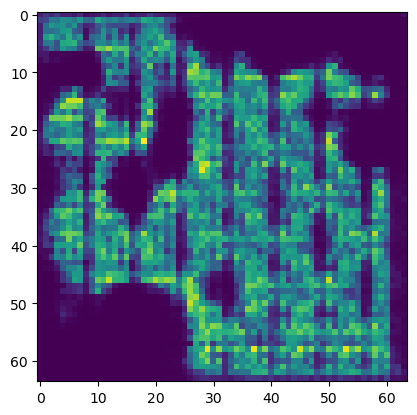

epoch = 301
Gen loss = tf.Tensor(0.051826485, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020247415, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 302
Gen loss = tf.Tensor(0.05471847, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020046296, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 303
Gen loss = tf.Tensor(0.06121333, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015626017, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 304
Gen loss = tf.Tensor(0.06333442, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015944311, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 305
Gen loss = tf.Tensor(0.05999806, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017098848, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 306
Gen loss = tf.Tensor(0.053227168, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020691667, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 307
Gen loss = tf.Tensor(0.052055113, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.019

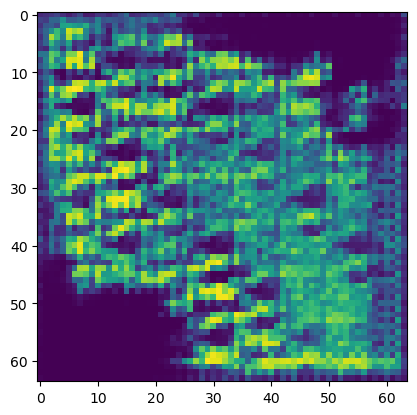

epoch = 311
Gen loss = tf.Tensor(0.05402014, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020157725, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 312
Gen loss = tf.Tensor(0.05663734, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017483896, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 313
Gen loss = tf.Tensor(0.05557373, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020014463, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 314
Gen loss = tf.Tensor(0.055105045, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.019211516, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 315
Gen loss = tf.Tensor(0.05222748, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02044416, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 316
Gen loss = tf.Tensor(0.04881033, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02190692, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 317
Gen loss = tf.Tensor(0.058561713, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016283

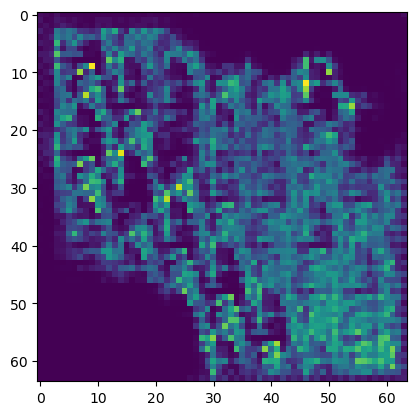

epoch = 321
Gen loss = tf.Tensor(0.055964407, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018280132, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 322
Gen loss = tf.Tensor(0.060405713, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016542062, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 323
Gen loss = tf.Tensor(0.060105637, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016077613, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 324
Gen loss = tf.Tensor(0.049200386, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024678828, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 325
Gen loss = tf.Tensor(0.057377174, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017856795, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 326
Gen loss = tf.Tensor(0.05081424, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020459313, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 327
Gen loss = tf.Tensor(0.054171696, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.

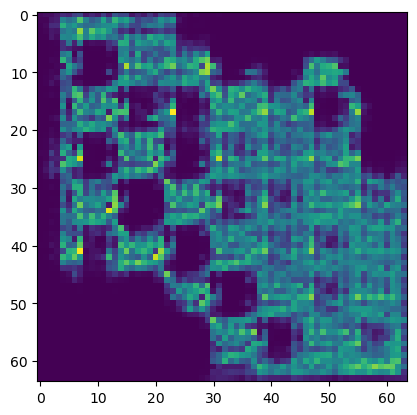

epoch = 331
Gen loss = tf.Tensor(0.0478657, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.022824736, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 332
Gen loss = tf.Tensor(0.062115382, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01588278, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 333
Gen loss = tf.Tensor(0.07871107, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00999373, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 334
Gen loss = tf.Tensor(0.060373455, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.019600416, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 335
Gen loss = tf.Tensor(0.05304519, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020910092, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 336
Gen loss = tf.Tensor(0.057211522, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018826932, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 337
Gen loss = tf.Tensor(0.06074311, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016043

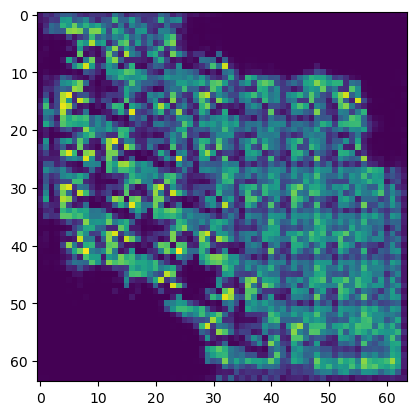

epoch = 341
Gen loss = tf.Tensor(0.055998698, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02052453, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 342
Gen loss = tf.Tensor(0.045361165, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024702042, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 343
Gen loss = tf.Tensor(0.051308334, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020710304, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 344
Gen loss = tf.Tensor(0.05134851, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.021984104, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 345
Gen loss = tf.Tensor(0.05290234, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.022867944, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 346
Gen loss = tf.Tensor(0.058119535, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017917275, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 347
Gen loss = tf.Tensor(0.059077453, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01

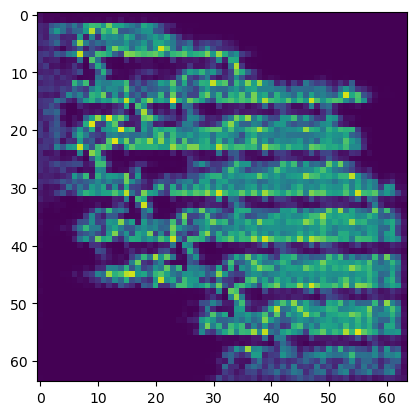

epoch = 351
Gen loss = tf.Tensor(0.07232821, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0110731535, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 352
Gen loss = tf.Tensor(0.066686034, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017193818, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 353
Gen loss = tf.Tensor(0.0651758, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016233176, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 354
Gen loss = tf.Tensor(0.056997314, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01967004, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 355
Gen loss = tf.Tensor(0.07132423, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011440814, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 356
Gen loss = tf.Tensor(0.073296174, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011024288, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 357
Gen loss = tf.Tensor(0.08752407, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0077

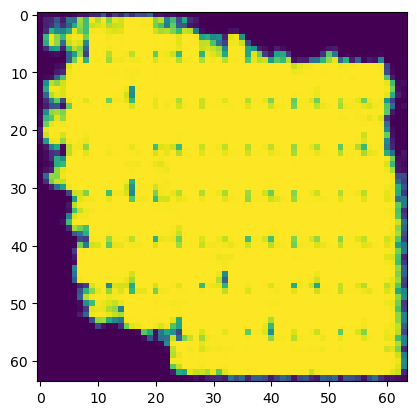

epoch = 361
Gen loss = tf.Tensor(0.07740021, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011361491, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 362
Gen loss = tf.Tensor(0.10724596, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0069923326, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 363
Gen loss = tf.Tensor(0.09264083, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010952326, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 364
Gen loss = tf.Tensor(0.08842386, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009697295, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 365
Gen loss = tf.Tensor(0.092766136, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007392612, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 366
Gen loss = tf.Tensor(0.07989455, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011891387, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 367
Gen loss = tf.Tensor(0.07360625, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0122

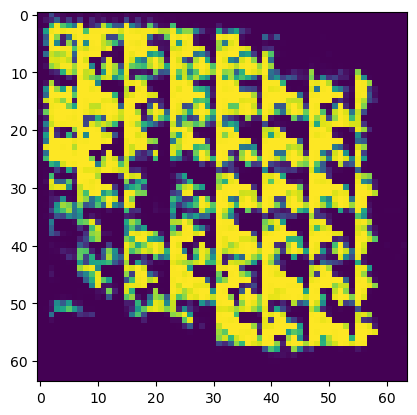

epoch = 371
Gen loss = tf.Tensor(0.078572996, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010136579, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 372
Gen loss = tf.Tensor(0.09395381, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0064957957, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 373
Gen loss = tf.Tensor(0.07042143, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014560037, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 374
Gen loss = tf.Tensor(0.07723153, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009796358, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 375
Gen loss = tf.Tensor(0.08706223, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0075257258, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 376
Gen loss = tf.Tensor(0.08703991, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008194631, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 377
Gen loss = tf.Tensor(0.0800916, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0093

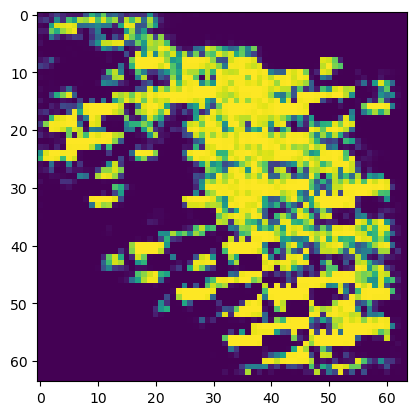

epoch = 381
Gen loss = tf.Tensor(0.088067584, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0073702107, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 382
Gen loss = tf.Tensor(0.08521036, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008517618, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 383
Gen loss = tf.Tensor(0.08332958, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007836874, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 384
Gen loss = tf.Tensor(0.08400192, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0075084637, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 385
Gen loss = tf.Tensor(0.0791112, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0115261255, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 386
Gen loss = tf.Tensor(0.095007986, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0060889143, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 387
Gen loss = tf.Tensor(0.08463482, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0

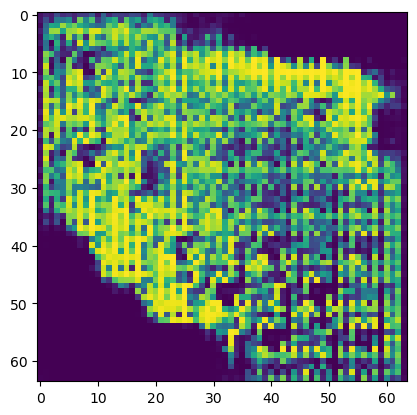

epoch = 391
Gen loss = tf.Tensor(0.071102716, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013651947, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 392
Gen loss = tf.Tensor(0.06527059, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017362501, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 393
Gen loss = tf.Tensor(0.049525313, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02951885, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 394
Gen loss = tf.Tensor(0.055825327, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013311441, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 395
Gen loss = tf.Tensor(0.09674364, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0033593825, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 396
Gen loss = tf.Tensor(0.06706713, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017076584, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 397
Gen loss = tf.Tensor(0.060285587, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02

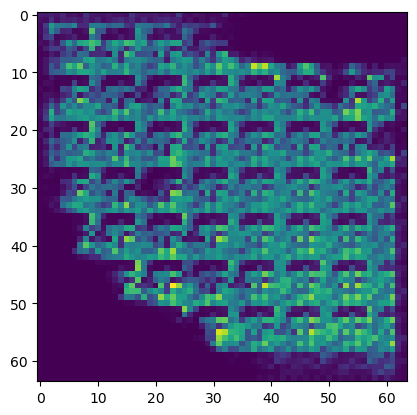

epoch = 401
Gen loss = tf.Tensor(0.07594679, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013971378, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 402
Gen loss = tf.Tensor(0.06431765, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015145366, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 403
Gen loss = tf.Tensor(0.078015715, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013807981, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 404
Gen loss = tf.Tensor(0.080267206, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0099892225, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 405
Gen loss = tf.Tensor(0.06567154, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014340842, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 406
Gen loss = tf.Tensor(0.06558754, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017144505, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 407
Gen loss = tf.Tensor(0.066515826, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01

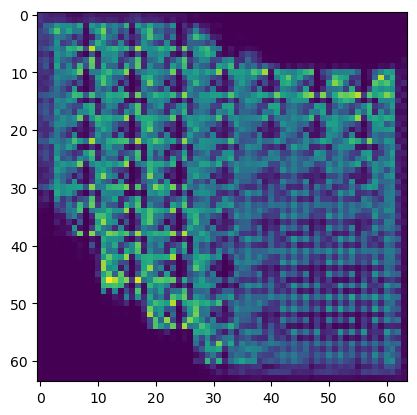

epoch = 411
Gen loss = tf.Tensor(0.064062275, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015688414, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 412
Gen loss = tf.Tensor(0.076825775, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0116373105, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 413
Gen loss = tf.Tensor(0.069338, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014646505, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 414
Gen loss = tf.Tensor(0.06989029, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0133112455, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 415
Gen loss = tf.Tensor(0.06957253, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015080409, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 416
Gen loss = tf.Tensor(0.07259548, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015945578, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 417
Gen loss = tf.Tensor(0.07307454, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0141

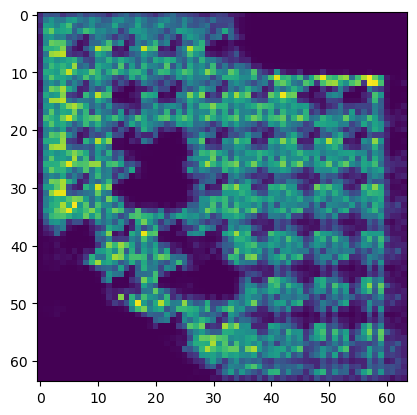

epoch = 421
Gen loss = tf.Tensor(0.059908036, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018253518, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 422
Gen loss = tf.Tensor(0.07084645, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017518451, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 423
Gen loss = tf.Tensor(0.08383682, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010802005, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 424
Gen loss = tf.Tensor(0.088273495, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008536601, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 425
Gen loss = tf.Tensor(0.063041486, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01815621, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 426
Gen loss = tf.Tensor(0.06780381, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014674102, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 427
Gen loss = tf.Tensor(0.06832684, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0146

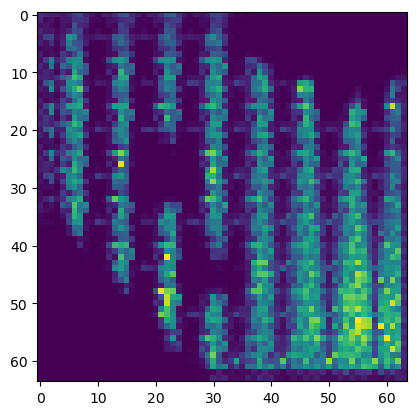

epoch = 431
Gen loss = tf.Tensor(0.07034194, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013213665, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 432
Gen loss = tf.Tensor(0.08568876, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011440072, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 433
Gen loss = tf.Tensor(0.12761807, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0029275648, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 434
Gen loss = tf.Tensor(0.14053176, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0021746305, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 435
Gen loss = tf.Tensor(0.14444481, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0020170605, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 436
Gen loss = tf.Tensor(0.13846329, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0032884157, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 437
Gen loss = tf.Tensor(0.099071264, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0

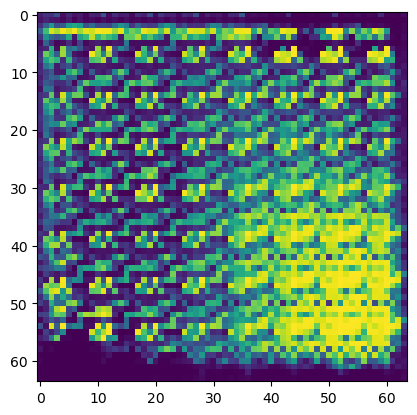

epoch = 441
Gen loss = tf.Tensor(0.1017896, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0076057487, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 442
Gen loss = tf.Tensor(0.10893362, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004821329, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 443
Gen loss = tf.Tensor(0.086314514, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0116712805, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 444
Gen loss = tf.Tensor(0.07511319, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011338268, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 445
Gen loss = tf.Tensor(0.08192408, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009746071, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 446
Gen loss = tf.Tensor(0.084802285, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008615494, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 447
Gen loss = tf.Tensor(0.08869814, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008

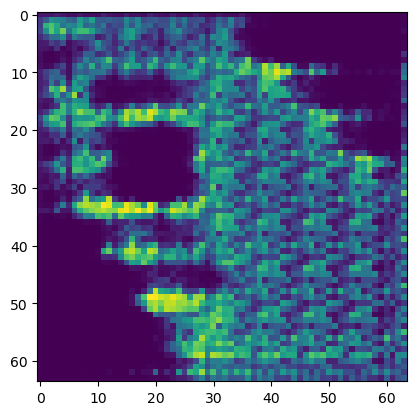

epoch = 451
Gen loss = tf.Tensor(0.064778134, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015967859, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 452
Gen loss = tf.Tensor(0.07396947, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011488593, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 453
Gen loss = tf.Tensor(0.06421644, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015220211, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 454
Gen loss = tf.Tensor(0.0763854, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011385534, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 455
Gen loss = tf.Tensor(0.07316885, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012502668, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 456
Gen loss = tf.Tensor(0.08287228, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010404271, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 457
Gen loss = tf.Tensor(0.07864293, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010733

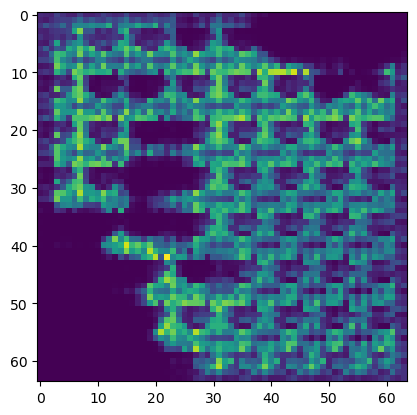

epoch = 461
Gen loss = tf.Tensor(0.08300009, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008575683, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 462
Gen loss = tf.Tensor(0.080833554, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010518953, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 463
Gen loss = tf.Tensor(0.07964146, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009338324, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 464
Gen loss = tf.Tensor(0.082069814, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011326269, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 465
Gen loss = tf.Tensor(0.07854199, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011373006, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 466
Gen loss = tf.Tensor(0.078233354, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011821348, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 467
Gen loss = tf.Tensor(0.08599317, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009

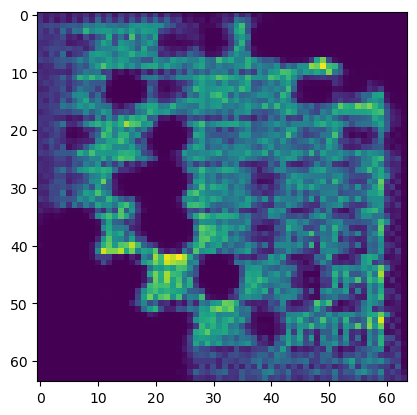

epoch = 471
Gen loss = tf.Tensor(0.066879824, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014618471, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 472
Gen loss = tf.Tensor(0.067431085, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015856931, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 473
Gen loss = tf.Tensor(0.07316912, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011781443, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 474
Gen loss = tf.Tensor(0.07812947, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010738315, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 475
Gen loss = tf.Tensor(0.09056635, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0072384416, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 476
Gen loss = tf.Tensor(0.08783442, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007374478, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 477
Gen loss = tf.Tensor(0.08647148, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008

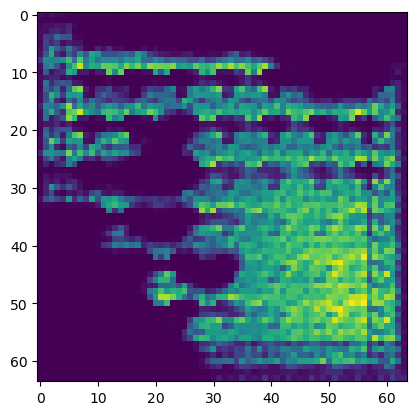

epoch = 481
Gen loss = tf.Tensor(0.08581347, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013871205, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 482
Gen loss = tf.Tensor(0.085706964, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011323684, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 483
Gen loss = tf.Tensor(0.08903093, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01248222, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 484
Gen loss = tf.Tensor(0.08233456, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014214854, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 485
Gen loss = tf.Tensor(0.07436812, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017033571, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 486
Gen loss = tf.Tensor(0.07414668, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015912635, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 487
Gen loss = tf.Tensor(0.07460141, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013081

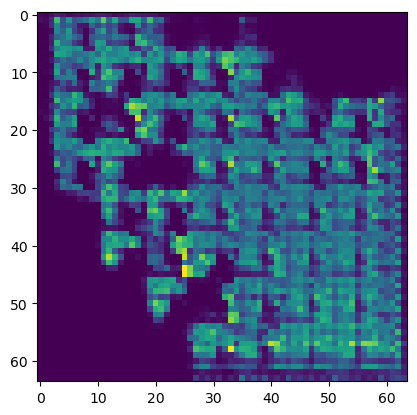

epoch = 491
Gen loss = tf.Tensor(0.07179224, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016013874, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 492
Gen loss = tf.Tensor(0.07752157, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013135725, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 493
Gen loss = tf.Tensor(0.08054825, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014089535, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 494
Gen loss = tf.Tensor(0.0739935, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01450916, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 495
Gen loss = tf.Tensor(0.07590123, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014927023, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 496
Gen loss = tf.Tensor(0.07236204, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013453836, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 497
Gen loss = tf.Tensor(0.07310846, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01204307

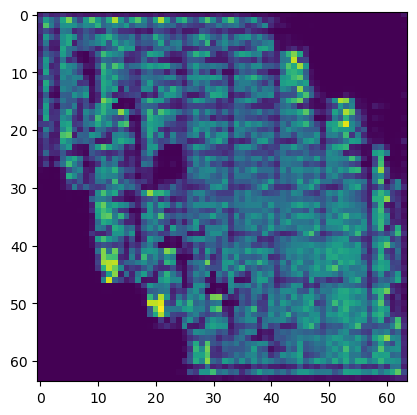

epoch = 501
Gen loss = tf.Tensor(0.07146087, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013033862, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 502
Gen loss = tf.Tensor(0.07530132, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011907783, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 503
Gen loss = tf.Tensor(0.070847, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013433179, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 504
Gen loss = tf.Tensor(0.08245548, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010972399, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 505
Gen loss = tf.Tensor(0.075465, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015193992, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 506
Gen loss = tf.Tensor(0.0698901, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016110426, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 507
Gen loss = tf.Tensor(0.07296193, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01293046, s

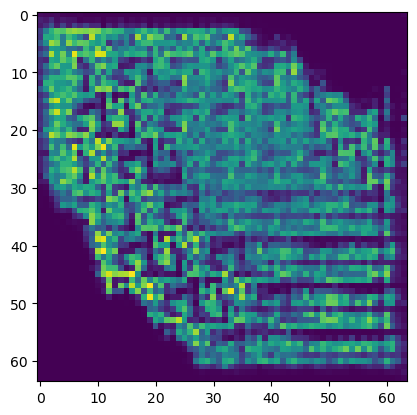

epoch = 511
Gen loss = tf.Tensor(0.076230414, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013713913, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 512
Gen loss = tf.Tensor(0.07981087, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011665936, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 513
Gen loss = tf.Tensor(0.08401553, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011040222, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 514
Gen loss = tf.Tensor(0.08763198, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011937124, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 515
Gen loss = tf.Tensor(0.081592284, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011525507, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 516
Gen loss = tf.Tensor(0.082143866, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009414264, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 517
Gen loss = tf.Tensor(0.082875736, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01

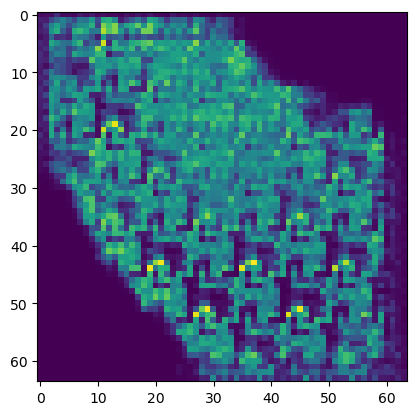

epoch = 521
Gen loss = tf.Tensor(0.0776134, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012262529, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 522
Gen loss = tf.Tensor(0.07920701, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0110250665, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 523
Gen loss = tf.Tensor(0.07975203, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01075721, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 524
Gen loss = tf.Tensor(0.08290395, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010602307, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 525
Gen loss = tf.Tensor(0.086968854, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011229364, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 526
Gen loss = tf.Tensor(0.08648465, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009703202, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 527
Gen loss = tf.Tensor(0.08377489, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009922

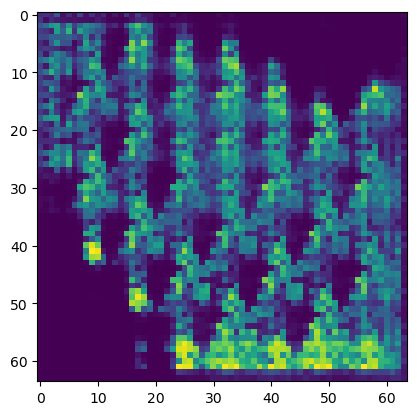

epoch = 531
Gen loss = tf.Tensor(0.09822117, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009635048, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 532
Gen loss = tf.Tensor(0.08596894, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012599322, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 533
Gen loss = tf.Tensor(0.082579106, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011182368, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 534
Gen loss = tf.Tensor(0.09402505, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0076704314, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 535
Gen loss = tf.Tensor(0.094908744, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0072596846, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 536
Gen loss = tf.Tensor(0.10715131, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0049030064, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 537
Gen loss = tf.Tensor(0.09350414, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0

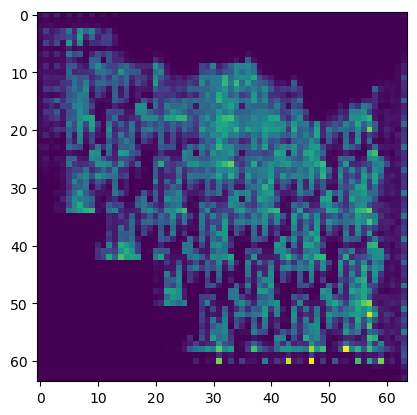

epoch = 541
Gen loss = tf.Tensor(0.09283428, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011136872, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 542
Gen loss = tf.Tensor(0.0977981, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007744447, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 543
Gen loss = tf.Tensor(0.094043195, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009544492, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 544
Gen loss = tf.Tensor(0.09401063, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008972089, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 545
Gen loss = tf.Tensor(0.08391051, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.014845569, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 546
Gen loss = tf.Tensor(0.077295564, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.016498262, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 547
Gen loss = tf.Tensor(0.08930903, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01014

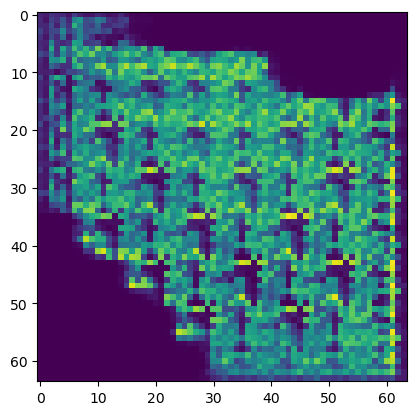

epoch = 551
Gen loss = tf.Tensor(0.08426325, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0126008205, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 552
Gen loss = tf.Tensor(0.08598745, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010172887, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 553
Gen loss = tf.Tensor(0.077099234, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011913865, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 554
Gen loss = tf.Tensor(0.07570673, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011867246, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 555
Gen loss = tf.Tensor(0.09080253, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010561386, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 556
Gen loss = tf.Tensor(0.08821059, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007579329, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 557
Gen loss = tf.Tensor(0.07752566, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0112

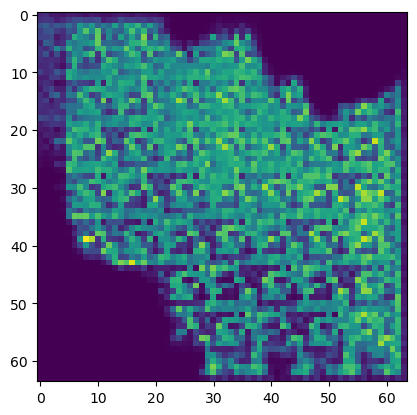

epoch = 561
Gen loss = tf.Tensor(0.08163009, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012023409, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 562
Gen loss = tf.Tensor(0.08520779, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010592033, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 563
Gen loss = tf.Tensor(0.081439555, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010236656, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 564
Gen loss = tf.Tensor(0.08591726, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009593253, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 565
Gen loss = tf.Tensor(0.09769402, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0065756454, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 566
Gen loss = tf.Tensor(0.11096744, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0051879417, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 567
Gen loss = tf.Tensor(0.100078076, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00

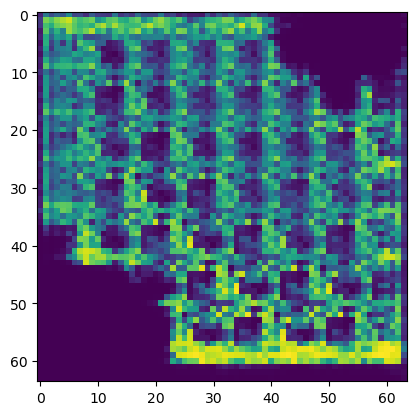

epoch = 571
Gen loss = tf.Tensor(0.0856264, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012307816, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 572
Gen loss = tf.Tensor(0.09699182, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0067248964, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 573
Gen loss = tf.Tensor(0.09401432, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0074234675, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 574
Gen loss = tf.Tensor(0.093003206, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008308837, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 575
Gen loss = tf.Tensor(0.08996942, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008539276, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 576
Gen loss = tf.Tensor(0.083919756, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012999958, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 577
Gen loss = tf.Tensor(0.09170249, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011

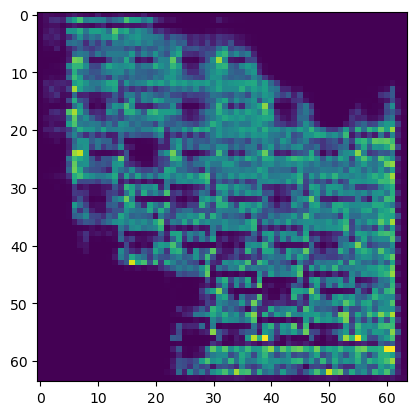

epoch = 581
Gen loss = tf.Tensor(0.09184019, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01142008, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 582
Gen loss = tf.Tensor(0.088092625, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012124657, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 583
Gen loss = tf.Tensor(0.09151289, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007959007, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 584
Gen loss = tf.Tensor(0.09590053, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0070760283, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 585
Gen loss = tf.Tensor(0.090565376, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00785995, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 586
Gen loss = tf.Tensor(0.08528793, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010361583, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 587
Gen loss = tf.Tensor(0.09643727, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00817

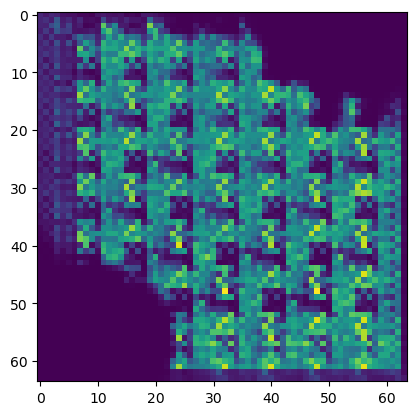

epoch = 591
Gen loss = tf.Tensor(0.09593562, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011521442, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 592
Gen loss = tf.Tensor(0.09750903, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0091969995, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 593
Gen loss = tf.Tensor(0.083269596, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012506602, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 594
Gen loss = tf.Tensor(0.081164636, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010142104, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 595
Gen loss = tf.Tensor(0.07683708, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010857077, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 596
Gen loss = tf.Tensor(0.0773201, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01223058, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 597
Gen loss = tf.Tensor(0.09248891, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00802

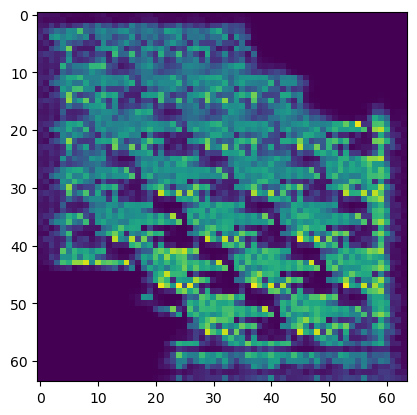

epoch = 601
Gen loss = tf.Tensor(0.09447882, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0071177096, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 602
Gen loss = tf.Tensor(0.092018284, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.006533726, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 603
Gen loss = tf.Tensor(0.091679364, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008190186, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 604
Gen loss = tf.Tensor(0.09927329, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00655044, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 605
Gen loss = tf.Tensor(0.095426105, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009383104, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 606
Gen loss = tf.Tensor(0.09955271, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0064033493, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 607
Gen loss = tf.Tensor(0.092709325, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0

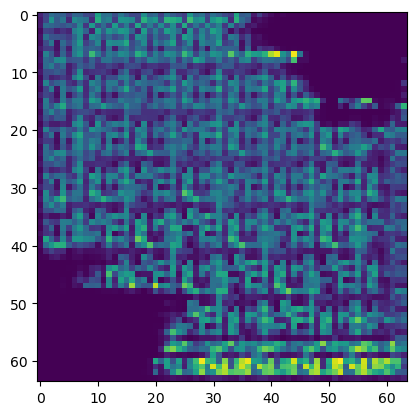

epoch = 611
Gen loss = tf.Tensor(0.09258491, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007264993, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 612
Gen loss = tf.Tensor(0.09694334, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007525407, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 613
Gen loss = tf.Tensor(0.10685179, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0061031473, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 614
Gen loss = tf.Tensor(0.10913228, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004278887, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 615
Gen loss = tf.Tensor(0.09675771, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00771745, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 616
Gen loss = tf.Tensor(0.10301583, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0066056824, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 617
Gen loss = tf.Tensor(0.11268795, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00498

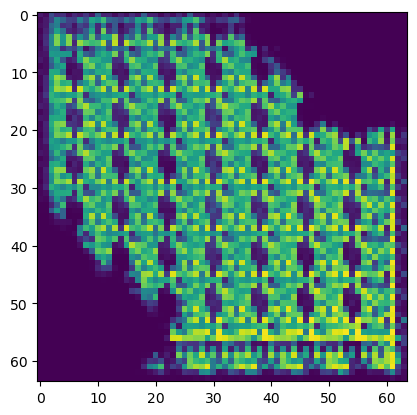

epoch = 621
Gen loss = tf.Tensor(0.114247076, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0053833295, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 622
Gen loss = tf.Tensor(0.09794408, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015046323, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 623
Gen loss = tf.Tensor(0.09774991, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0069303336, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 624
Gen loss = tf.Tensor(0.11260128, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0071193636, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 625
Gen loss = tf.Tensor(0.12699029, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0049782875, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 626
Gen loss = tf.Tensor(0.11612251, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0059516444, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 627
Gen loss = tf.Tensor(0.106648006, shape=(), dtype=float32)
Disc loss = tf.Tensor(0

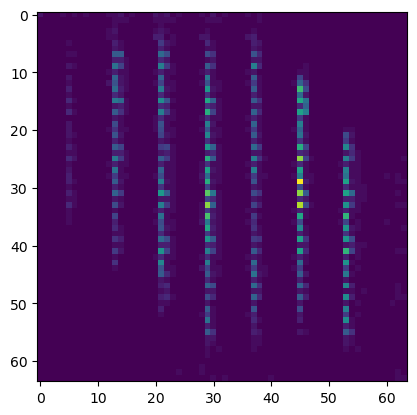

epoch = 631
Gen loss = tf.Tensor(0.15292588, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0007678797, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 632
Gen loss = tf.Tensor(0.15773076, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.000378111, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 633
Gen loss = tf.Tensor(0.16218796, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00039199722, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 634
Gen loss = tf.Tensor(0.15828063, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00051117403, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 635
Gen loss = tf.Tensor(0.15882337, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0003856098, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 636
Gen loss = tf.Tensor(0.13889547, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.001193626, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 637
Gen loss = tf.Tensor(0.14840706, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.

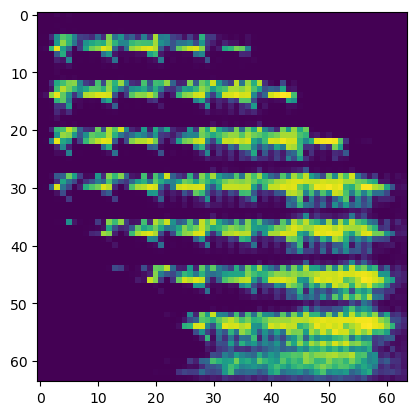

epoch = 641
Gen loss = tf.Tensor(0.13154484, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008408715, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 642
Gen loss = tf.Tensor(0.112937026, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0076874536, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 643
Gen loss = tf.Tensor(0.09246364, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01074442, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 644
Gen loss = tf.Tensor(0.10013124, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008615647, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 645
Gen loss = tf.Tensor(0.10507618, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01266358, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 646
Gen loss = tf.Tensor(0.10386797, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.017631106, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 647
Gen loss = tf.Tensor(0.11570794, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005638

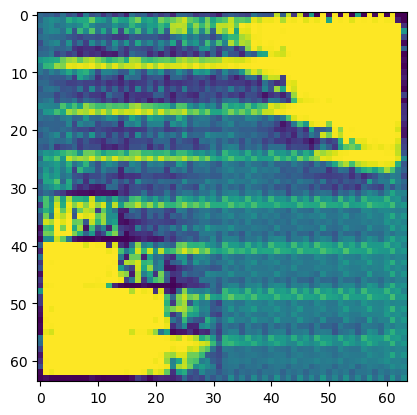

epoch = 651
Gen loss = tf.Tensor(0.12162876, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.006808982, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 652
Gen loss = tf.Tensor(0.10995076, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0066061444, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 653
Gen loss = tf.Tensor(0.10369372, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008320157, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 654
Gen loss = tf.Tensor(0.12474302, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0044927625, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 655
Gen loss = tf.Tensor(0.10877642, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008090199, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 656
Gen loss = tf.Tensor(0.09657458, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013975559, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 657
Gen loss = tf.Tensor(0.114217706, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007

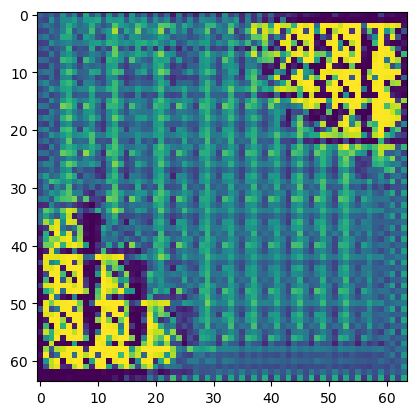

epoch = 661
Gen loss = tf.Tensor(0.10748427, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008662316, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 662
Gen loss = tf.Tensor(0.09815877, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008401732, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 663
Gen loss = tf.Tensor(0.09378323, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008195436, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 664
Gen loss = tf.Tensor(0.09859514, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008255358, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 665
Gen loss = tf.Tensor(0.10430923, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008230848, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 666
Gen loss = tf.Tensor(0.09653472, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010907567, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 667
Gen loss = tf.Tensor(0.088422105, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01380

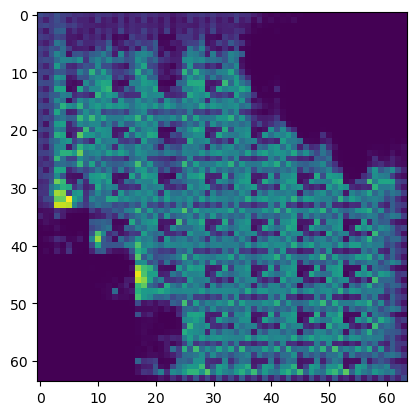

epoch = 671
Gen loss = tf.Tensor(0.09596797, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008665957, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 672
Gen loss = tf.Tensor(0.112396434, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0056554577, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 673
Gen loss = tf.Tensor(0.09524349, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008825387, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 674
Gen loss = tf.Tensor(0.09958523, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009152338, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 675
Gen loss = tf.Tensor(0.11146708, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005546043, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 676
Gen loss = tf.Tensor(0.10747198, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0065275286, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 677
Gen loss = tf.Tensor(0.0996821, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0089

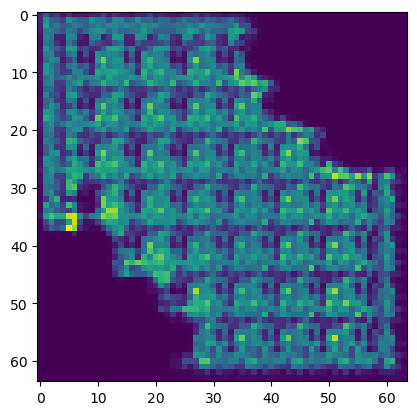

epoch = 681
Gen loss = tf.Tensor(0.0831591, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.012656919, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 682
Gen loss = tf.Tensor(0.09136704, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010768369, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 683
Gen loss = tf.Tensor(0.10164263, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0062666573, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 684
Gen loss = tf.Tensor(0.097775586, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007258514, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 685
Gen loss = tf.Tensor(0.08472393, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010110653, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 686
Gen loss = tf.Tensor(0.09542056, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00804494, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 687
Gen loss = tf.Tensor(0.09927164, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007846

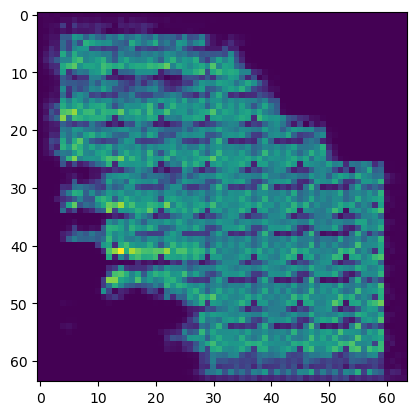

epoch = 691
Gen loss = tf.Tensor(0.11307506, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0068661864, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 692
Gen loss = tf.Tensor(0.11950873, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0064624734, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 693
Gen loss = tf.Tensor(0.12971514, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0054230755, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 694
Gen loss = tf.Tensor(0.115306094, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007440078, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 695
Gen loss = tf.Tensor(0.12707064, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.006877544, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 696
Gen loss = tf.Tensor(0.1299554, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004476165, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 697
Gen loss = tf.Tensor(0.12301001, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.003

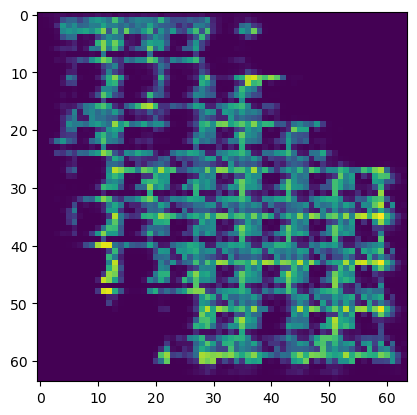

epoch = 701
Gen loss = tf.Tensor(0.093847744, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011116419, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 702
Gen loss = tf.Tensor(0.10070556, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010904466, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 703
Gen loss = tf.Tensor(0.09652345, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011966547, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 704
Gen loss = tf.Tensor(0.124964155, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005408568, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 705
Gen loss = tf.Tensor(0.14753994, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004006771, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 706
Gen loss = tf.Tensor(0.12491147, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.006048627, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 707
Gen loss = tf.Tensor(0.14593215, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0026

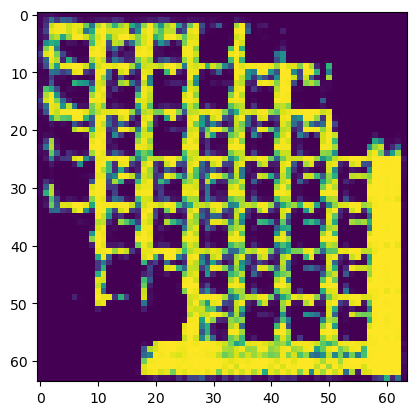

epoch = 711
Gen loss = tf.Tensor(0.13183828, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0022388515, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 712
Gen loss = tf.Tensor(0.11384137, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.003940376, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 713
Gen loss = tf.Tensor(0.12531993, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005777801, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 714
Gen loss = tf.Tensor(0.121318884, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004431363, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 715
Gen loss = tf.Tensor(0.10348519, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.006902412, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 716
Gen loss = tf.Tensor(0.10946548, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0053083235, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 717
Gen loss = tf.Tensor(0.11839916, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004

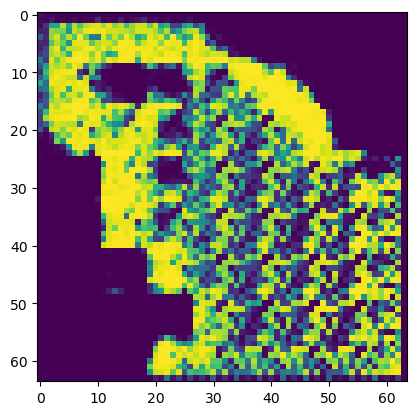

epoch = 721
Gen loss = tf.Tensor(0.108299196, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008016819, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 722
Gen loss = tf.Tensor(0.118831106, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0034745063, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 723
Gen loss = tf.Tensor(0.10867372, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.006344281, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 724
Gen loss = tf.Tensor(0.119356915, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005964422, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 725
Gen loss = tf.Tensor(0.122532085, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0037223399, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 726
Gen loss = tf.Tensor(0.121075906, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0038555379, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 727
Gen loss = tf.Tensor(0.11949613, shape=(), dtype=float32)
Disc loss = tf.Tensor(

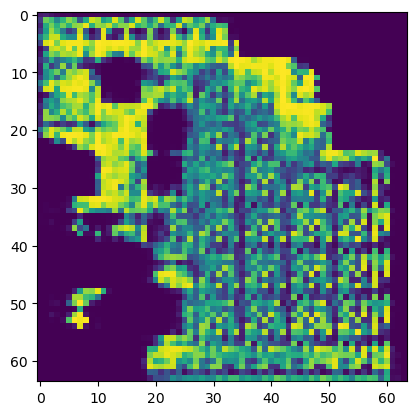

epoch = 731
Gen loss = tf.Tensor(0.10404009, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005284267, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 732
Gen loss = tf.Tensor(0.11922483, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004143478, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 733
Gen loss = tf.Tensor(0.12246151, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0034900024, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 734
Gen loss = tf.Tensor(0.120895185, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0039833114, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 735
Gen loss = tf.Tensor(0.1115309, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0059145684, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 736
Gen loss = tf.Tensor(0.1094654, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0063018543, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 737
Gen loss = tf.Tensor(0.1088324, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0061

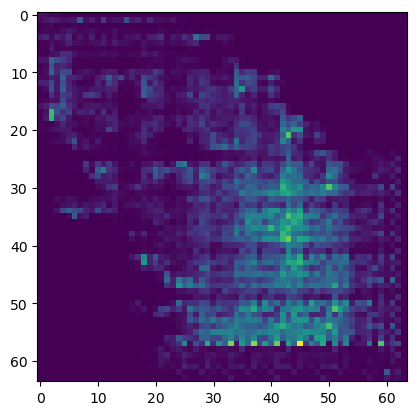

epoch = 741
Gen loss = tf.Tensor(0.092104234, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0070646126, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 742
Gen loss = tf.Tensor(0.12218793, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0034323703, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 743
Gen loss = tf.Tensor(0.14670272, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0025411095, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 744
Gen loss = tf.Tensor(0.15694672, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0020612276, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 745
Gen loss = tf.Tensor(0.16556607, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0017076114, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 746
Gen loss = tf.Tensor(0.15847765, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.002631482, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 747
Gen loss = tf.Tensor(0.12676726, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.

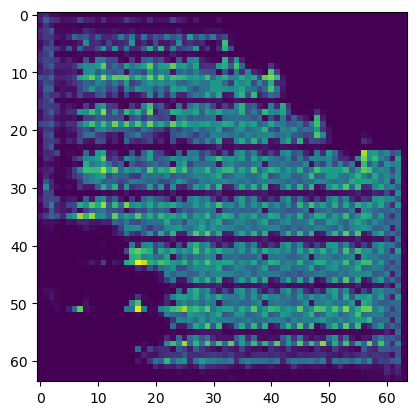

epoch = 751
Gen loss = tf.Tensor(0.1227576, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0042443243, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 752
Gen loss = tf.Tensor(0.13360357, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004488621, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 753
Gen loss = tf.Tensor(0.10080793, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008214815, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 754
Gen loss = tf.Tensor(0.1021807, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0083952295, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 755
Gen loss = tf.Tensor(0.10429013, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0074982396, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 756
Gen loss = tf.Tensor(0.099479154, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0089723235, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 757
Gen loss = tf.Tensor(0.08800947, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013

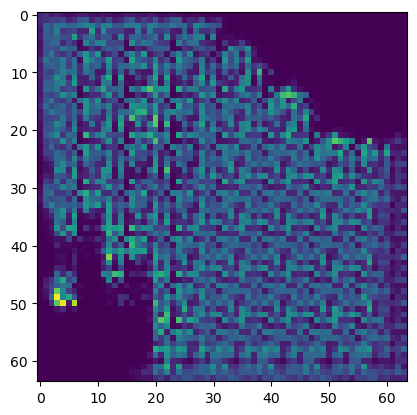

epoch = 761
Gen loss = tf.Tensor(0.10841056, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007898617, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 762
Gen loss = tf.Tensor(0.11757066, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005771545, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 763
Gen loss = tf.Tensor(0.12305077, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004424803, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 764
Gen loss = tf.Tensor(0.13107218, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0034148195, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 765
Gen loss = tf.Tensor(0.13904537, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0023110642, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 766
Gen loss = tf.Tensor(0.1265334, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0044752075, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 767
Gen loss = tf.Tensor(0.11216494, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0052

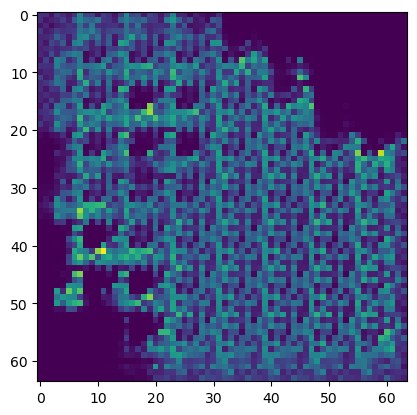

epoch = 771
Gen loss = tf.Tensor(0.11936892, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0043325564, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 772
Gen loss = tf.Tensor(0.11589444, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004021379, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 773
Gen loss = tf.Tensor(0.10285902, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0078873215, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 774
Gen loss = tf.Tensor(0.10329368, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0071685594, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 775
Gen loss = tf.Tensor(0.11276344, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0054708123, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 776
Gen loss = tf.Tensor(0.10342814, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0074802125, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 777
Gen loss = tf.Tensor(0.0988154, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00

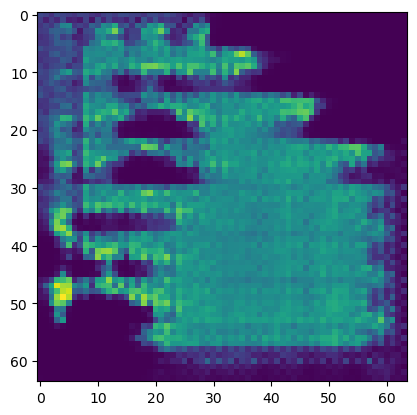

epoch = 781
Gen loss = tf.Tensor(0.12800057, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0045664366, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 782
Gen loss = tf.Tensor(0.10750662, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0071512605, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 783
Gen loss = tf.Tensor(0.10000675, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010259662, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 784
Gen loss = tf.Tensor(0.11662253, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0070090718, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 785
Gen loss = tf.Tensor(0.10907668, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007899965, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 786
Gen loss = tf.Tensor(0.11735477, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00507653, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 787
Gen loss = tf.Tensor(0.11657219, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0056

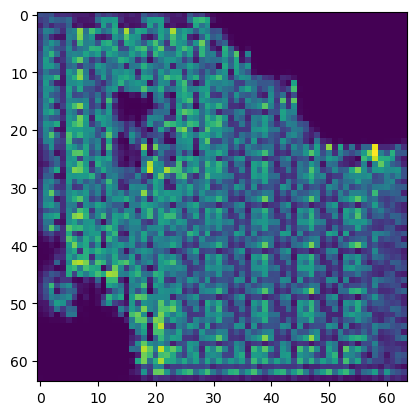

epoch = 791
Gen loss = tf.Tensor(0.113846645, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.006326174, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 792
Gen loss = tf.Tensor(0.10659998, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008110399, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 793
Gen loss = tf.Tensor(0.1006896, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00819615, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 794
Gen loss = tf.Tensor(0.1028427, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008718333, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 795
Gen loss = tf.Tensor(0.11105762, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.006471639, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 796
Gen loss = tf.Tensor(0.10171935, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0069927205, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 797
Gen loss = tf.Tensor(0.10536593, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0059605

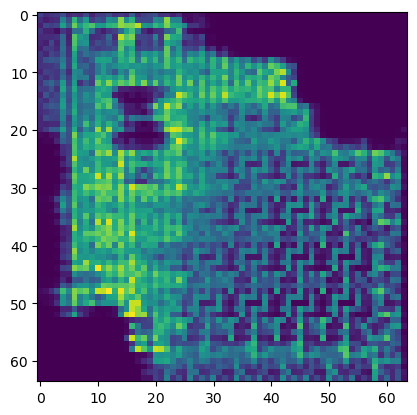

epoch = 801
Gen loss = tf.Tensor(0.10663713, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008082758, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 802
Gen loss = tf.Tensor(0.10370924, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0071853423, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 803
Gen loss = tf.Tensor(0.10236601, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007444952, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 804
Gen loss = tf.Tensor(0.106433526, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.006505636, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 805
Gen loss = tf.Tensor(0.09846666, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0073857647, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 806
Gen loss = tf.Tensor(0.10159841, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008490675, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 807
Gen loss = tf.Tensor(0.10352393, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007

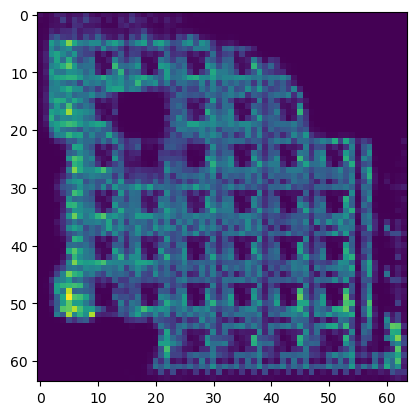

epoch = 811
Gen loss = tf.Tensor(0.11916531, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0051467726, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 812
Gen loss = tf.Tensor(0.11762261, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005335134, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 813
Gen loss = tf.Tensor(0.106812775, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005900142, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 814
Gen loss = tf.Tensor(0.110739104, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0063643632, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 815
Gen loss = tf.Tensor(0.10243213, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008050574, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 816
Gen loss = tf.Tensor(0.09670455, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0067763343, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 817
Gen loss = tf.Tensor(0.10878975, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0

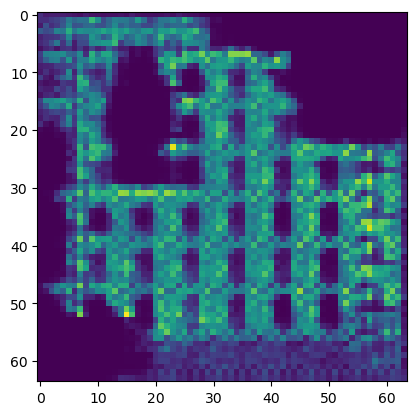

epoch = 821
Gen loss = tf.Tensor(0.12424183, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.003985278, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 822
Gen loss = tf.Tensor(0.110826544, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00577536, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 823
Gen loss = tf.Tensor(0.11479337, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00473142, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 824
Gen loss = tf.Tensor(0.10268811, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0060205497, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 825
Gen loss = tf.Tensor(0.11415582, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005091759, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 826
Gen loss = tf.Tensor(0.11532438, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005466489, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 827
Gen loss = tf.Tensor(0.10732637, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005781

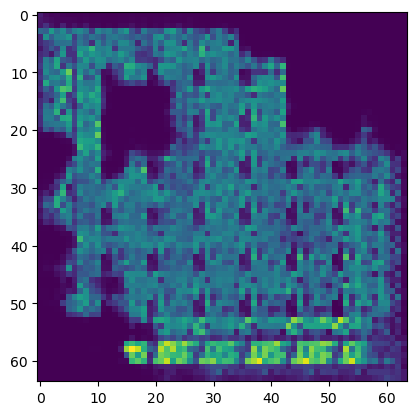

epoch = 831
Gen loss = tf.Tensor(0.114846885, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0072368537, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 832
Gen loss = tf.Tensor(0.108987615, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.006835728, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 833
Gen loss = tf.Tensor(0.09701424, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008974635, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 834
Gen loss = tf.Tensor(0.11712724, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0075140987, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 835
Gen loss = tf.Tensor(0.106480435, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0068882066, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 836
Gen loss = tf.Tensor(0.12722528, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008356019, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 837
Gen loss = tf.Tensor(0.12186685, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.

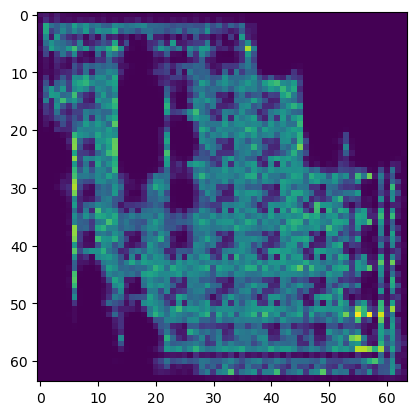

epoch = 841
Gen loss = tf.Tensor(0.124235876, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0043271095, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 842
Gen loss = tf.Tensor(0.11357653, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005943446, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 843
Gen loss = tf.Tensor(0.11877538, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0059778416, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 844
Gen loss = tf.Tensor(0.1008941, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009090926, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 845
Gen loss = tf.Tensor(0.11330772, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.009919796, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 846
Gen loss = tf.Tensor(0.108422995, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008686041, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 847
Gen loss = tf.Tensor(0.097856246, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01

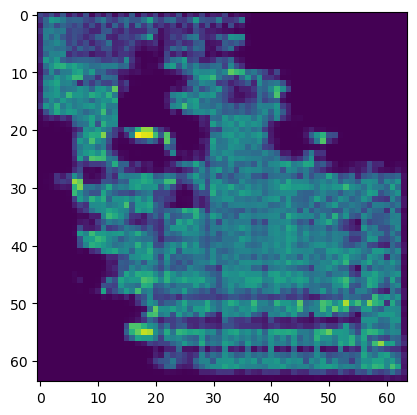

epoch = 851
Gen loss = tf.Tensor(0.10731096, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0075932075, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 852
Gen loss = tf.Tensor(0.09283718, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0131080635, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 853
Gen loss = tf.Tensor(0.0979693, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.010983418, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 854
Gen loss = tf.Tensor(0.11120837, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00628048, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 855
Gen loss = tf.Tensor(0.11674399, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0060976334, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 856
Gen loss = tf.Tensor(0.12110613, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0052557285, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 857
Gen loss = tf.Tensor(0.11869542, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0054

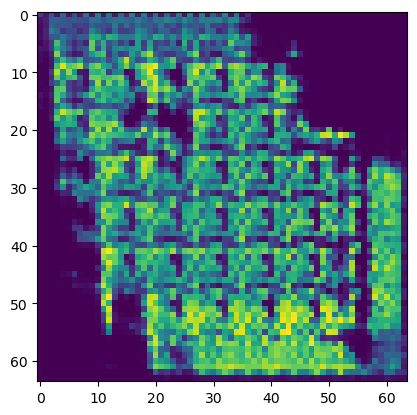

epoch = 861
Gen loss = tf.Tensor(0.11125125, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.006311599, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 862
Gen loss = tf.Tensor(0.12652962, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0039210515, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 863
Gen loss = tf.Tensor(0.12868355, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0040035085, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 864
Gen loss = tf.Tensor(0.1475309, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0036037245, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 865
Gen loss = tf.Tensor(0.13768566, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0040833913, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 866
Gen loss = tf.Tensor(0.13426177, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0068655903, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 867
Gen loss = tf.Tensor(0.12554806, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00

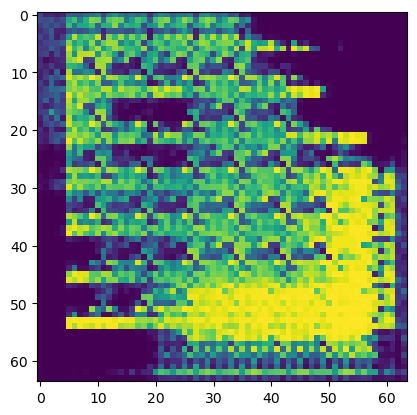

epoch = 871
Gen loss = tf.Tensor(0.1494357, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0021534837, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 872
Gen loss = tf.Tensor(0.14621462, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0020614972, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 873
Gen loss = tf.Tensor(0.124123625, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004069866, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 874
Gen loss = tf.Tensor(0.123895876, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0065685753, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 875
Gen loss = tf.Tensor(0.15573518, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0034760025, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 876
Gen loss = tf.Tensor(0.1447003, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.006090761, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 877
Gen loss = tf.Tensor(0.12169425, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00

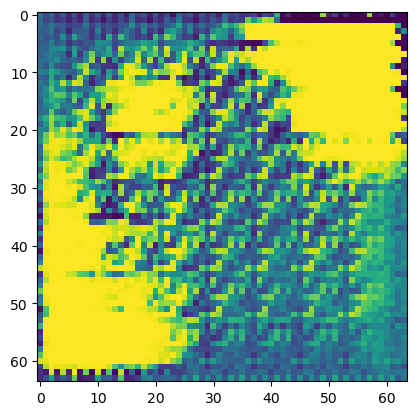

epoch = 881
Gen loss = tf.Tensor(0.11304112, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.007987996, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 882
Gen loss = tf.Tensor(0.13705851, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0035279726, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 883
Gen loss = tf.Tensor(0.13171697, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0037616892, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 884
Gen loss = tf.Tensor(0.10928723, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.008462414, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 885
Gen loss = tf.Tensor(0.10994385, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00659481, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 886
Gen loss = tf.Tensor(0.12198169, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.005677987, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 887
Gen loss = tf.Tensor(0.11006909, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.00728

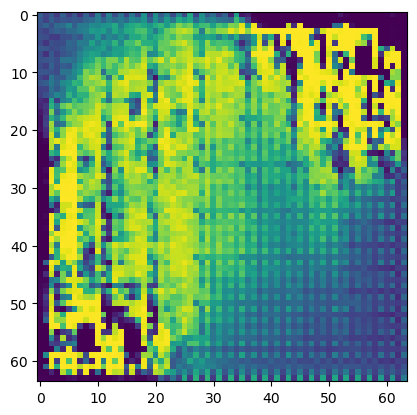

epoch = 891
Gen loss = tf.Tensor(0.11563089, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.011340722, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 892
Gen loss = tf.Tensor(0.12509091, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0049599833, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 893
Gen loss = tf.Tensor(0.11663266, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0053709676, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 894
Gen loss = tf.Tensor(0.1284664, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0036026852, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 895
Gen loss = tf.Tensor(0.13001323, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0061343713, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 896
Gen loss = tf.Tensor(0.1265251, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0043004733, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 897


In [273]:

gen_losses, disc_losses, generated_map, disc_accuracies = train(training_data, N_EPOCHS)


Denormalize, save and display generated map output

In [1]:
# denormalise generated map

generated_map *= 255

generated_map = generated_map.numpy()

generated_map = np.reshape(generated_map, (64,64))

generated_map = np.round(generated_map,0)
print(generated_map.shape)

#write generated map to csv


np.savetxt('generated_map.csv', generated_map, delimiter=',', fmt='%i')

generated_map = generated_map.tolist()


plt.imshow(generated_map)

NameError: name 'generated_map' is not defined

# Graphs:

Losses

Text(0.5, 0, 'Epoch')

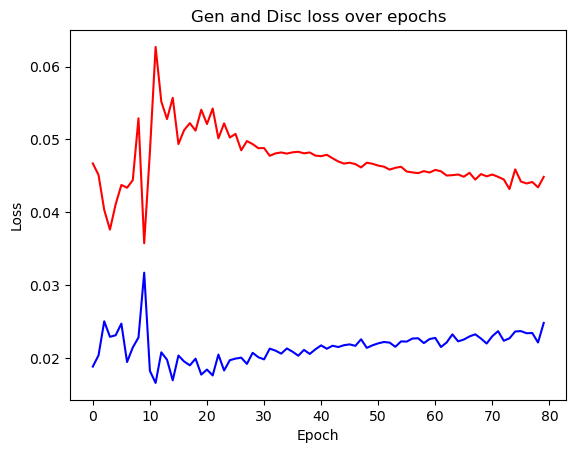

In [ ]:
epoch_list = [i for i in range(0,N_EPOCHS)]


plt.plot(epoch_list, disc_losses,  'r-')
plt.plot(epoch_list, gen_losses, 'b-')
plt.title('Gen and Disc loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Discriminator Accuracy

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1520,) + inhomogeneous part.

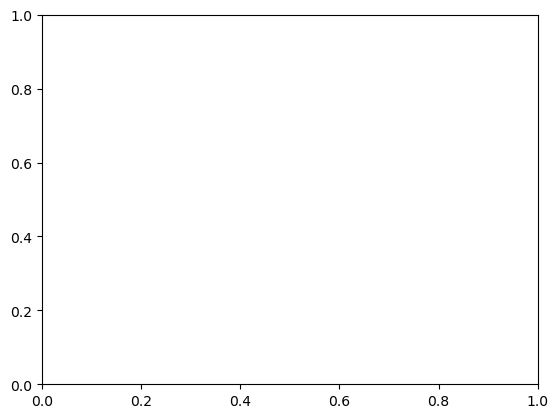

In [ ]:
plt.plot(epoch_list, disc_accuracies,  'r-')

plt.title('Disc accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')